# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 2D problem

### Manufactured solution


We use $u = x^2 + y^2$ for $x\in [-1,1]^2$ to manufacture the right hand side to be $f=4$ which is same as $f=-\Delta u$.

### Importing packages

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [21]:
np.random.seed(123)
pde_data_size = 1000
dim_d = 2
X_tr_pde = np.random.uniform(-1,1,pde_data_size*dim_d).reshape(pde_data_size,dim_d)


### Looking at the scatter plot of genrated 2d points

Text(0.5, 1.0, 'Randomly generated collocation points')

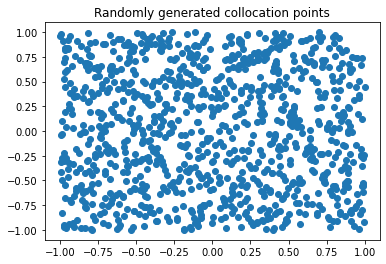

In [26]:
plt.scatter(X_tr_pde[:,0],X_tr_pde[:,1])
plt.title("Randomly generated collocation points")

### Defining RHS of pde

In [192]:
Y_tr_pde = -4*np.ones((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [193]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(1000, 2)

### Experiment with surface plotting( might help later while plotting the computed solution)

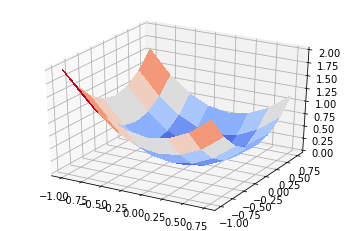

In [194]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


## BC data 

In [195]:
bc_data_size = 100

X_bc_left = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([-1*np.ones((bc_data_size,1)), X_bc_left], axis=1)

X_bc_bottom = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, -1*np.ones((bc_data_size,1))], axis=1)

X_bc_right = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([1*np.ones((bc_data_size,1)), X_bc_right], axis=1)

X_bc_top = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, 1*np.ones((bc_data_size,1))], axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top],axis=0)

In [196]:
Y_bc = X_bc[:,0:1]**2 + X_bc[:,1:]**2 
Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [197]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [370]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(30, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(1,
                                         name="dense_3")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("error occured in find gradient lambda layer of type {} as follows: ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: ".format(type(e)),e)
        
    def call(self, inputs):
        with tf.GradientTape() as gscope:
            gscope.watch(inputs)
            inputs_conc = keras.layers.concatenate(inputs) 
            layer_1 = self.dense_1(inputs_conc)
            layer_2 = self.dense_2(layer_1)
            layer_3 = self.dense_3(layer_2)
#         print("\n\nreached here 1 \n\n\n")
#         grad_layer = self.findGrad(layer_3, inputs)
        grad_layer = gscope.gradient(layer_3,inputs[0])
#         print("\n\nreached here 2 \n\n\n")
#         laplace_layer = self.findSecGrad(grad_layer, inputs)
#         print("\n\nreached here 3 \n\n\n")
#         print("\n\ layer_3 type:",type(layer_3)," \n\n\n")
#         print("\n\ grad_layer type:",type(grad_layer)," \n\n\n")
#         print(grad_layer)
        
        
        return layer_3, grad_layer




In [371]:
custom_model = CustomModel()

In [372]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
    print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

def no_loss(y_true,y_pred):
    print("\n\nreached here 3 \n\n\n")
    return y_true

In [373]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer="nadam",  run_eagerly=True )
# custom_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [374]:
custom_model.fit(x=[X_tr[0:3,0:1], X_tr[0:3,1:2]], y=[Y_tr[0:3,0:2],Y_tr[0:3,0:2]],epochs=1)


u_loss:  tf.Tensor(
[[0.]
 [0.]
 [0.]], shape=(3, 1), dtype=float32)

pde_loss:  tf.Tensor(
[[7.0509567]
 [7.0493326]
 [7.501477 ]], shape=(3, 1), dtype=float32)
1/1 [==============================] - 0s 902us/step - loss: 7.2006 - output_1_loss: 0.0000e+00 - output_2_loss: 7.2006


In [364]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-5))
custom_model.fit(x=X_tr, y=Y_tr,epochs=40)

Epoch 1/40


ValueError: in user code:

    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-356-eb592b01b3f4>:38 call  *
        inputs_conc = keras.layers.concatenate(inputs)
    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/layers/merge.py:927 concatenate  **
        return Concatenate(axis=axis, **kwargs)(inputs)
    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:897 __call__
        self._maybe_build(inputs)
    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2416 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/utils/tf_utils.py:316 wrapper
        output_shape = fn(instance, input_shape)
    /home/wickedboy_pc/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/layers/merge.py:493 build
        raise ValueError('A `Concatenate` layer should be called '

    ValueError: A `Concatenate` layer should be called on a list of at least 2 inputs


In [143]:
X_test_st = np.random.uniform(0,2,500).reshape(500,1)

In [144]:
Y_test = custom_model.predict(X_test_st)

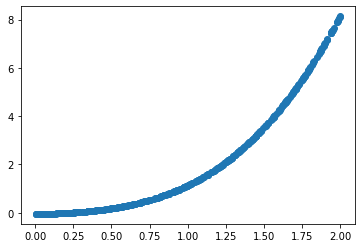

In [145]:
plt.scatter(X_test_st, Y_test[0][:,0])